In [1]:
%load_ext Cython

import os
cwd = os.getcwd()
cwd

'/Users/Riccardo/Documents/Workspace/MyNotebooks'

In [2]:
%%cython --cplus -f -I {cwd} --compile-args=-mmacosx-version-min=10.10 --compile-args=-std=c++11 --link-args=-mmacosx-version-min=10.10

cdef extern from "fillNaN.cpp":
    double generateValue()
    double* createHistory(int numValues)
    void destroyHistory(double* values)
    double* cloneHistory(const double* values, int numValues)
    void fillNaN(double* values, int numValues)
    void fillNaN_reversed(double* values, int numValues)


cdef class History:
    
    cdef:
        int numValues
        double * values
    
    def __cinit__(self, numValues=0):
        if numValues:
            self.numValues = numValues
            self.values = createHistory(numValues)
        else:
            self.numValues = 0
            self.values = NULL
            
    def __dealloc__(self):
        destroyHistory(self.values)
        
    def copy(self):
        cloned = History()
        cloned.values = cloneHistory(self.values, self.numValues)
        cloned.numValues = self.numValues
        return cloned
        
    def fillNaN(self):
        fillNaN(self.values, self.numValues)
    
    def fillNaN_reversed(self):
        fillNaN_reversed(self.values, self.numValues)
        
    def __len__(self):
        return self.numValues
    
    def __str__(self):
        return str(self.numValues)
        
    def __iter__(self):
        cdef int i
        return (self.values[i]
                for i in range(self.numValues))



/Users/Riccardo/anaconda/lib/python3.4/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [3]:
from IPython.display import display
from itertools import combinations
import time
import matplotlib
import os
import pandas as pd

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

# Different platforms require different functions to properly measure current timestamp:
if os.name == 'nt':
    now = time.clock
else:
    now = time.time

def run_benchmarks(X,
                   num_runs=10,
                   functions=None,
                   prepare_function=None):
    
    if type(X) is not list:
        X = list(X)
    
    assert functions, 'Please pass a sequence of functions to be tested'
    assert num_runs > 0, 'Number of runs must be strictly positive'
    
    def _name(function):
        return function.__name__
    
    def _measure(x, function):
        if prepare_function:
            x = prepare_function(x)
        T_0 = now()
        for i in range(num_runs):
            function(x)
        return (now() - T_0) / num_runs
    
    df = pd.DataFrame()
    for function in functions:
        Y = [_measure(x, function) for x in X]
        df[_name(function)] = pd.Series(data=Y,
                                        index=[str(x) for x in X])
            
        
    plt.figure()
    df.plot(title='$y=Log_{10}(T[f(x)])$',
            style='o-',
            logy=False,
            figsize=(15,5))
    
    if len(functions) >= 2:
        comb = combinations(((_name(function), df[_name(function)].values)
                             for function in functions), 2)
        for (nameA, timesA), (nameB, timesB) in comb:
            title = '$y=\\frac{T[%s]}{T[%s]}$' % (nameA[1:-1], nameB[1:-1])
            plt.figure()
            (df[nameA] / df[nameB]).plot(title=title,
                                         style='o-',
                                         figsize=(15,5))


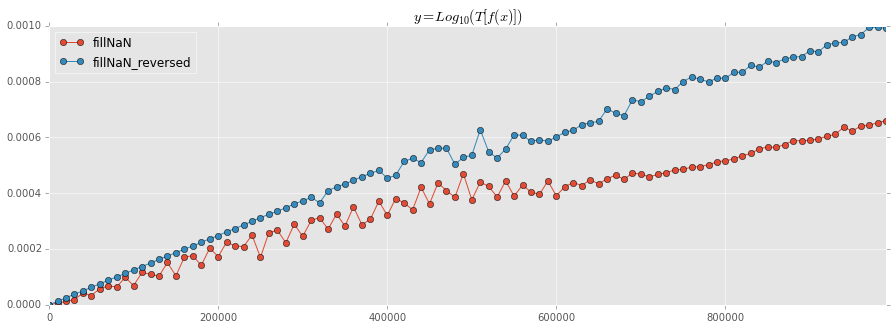

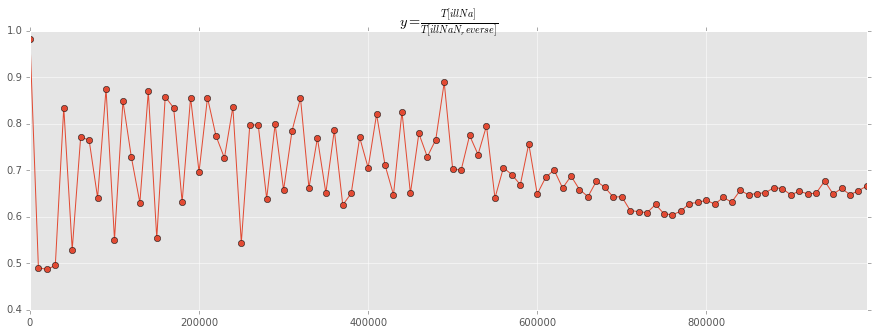

In [5]:
# Generates the objects:
X = [History(x)
     for x in range(0, 1000000, 10000)]

# Executes the benchmark:
run_benchmarks(X,
               num_runs=1000,
               functions=[History.fillNaN,
                          History.fillNaN_reversed],
               prepare_function=History.copy)

